In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from helper import plot_mnist


# Notes

- maybe it's a good idea to keep some learning goals in the introduction? 

  """By the end of this notebook, you will be able to:
  - Apply clustering techniques to both image and healthcare data
  - Interpret clustering results and evaluate their quality
  - Understand how clustering can support data-driven decision-making in healthcare

  Let's get started!
  """


# Table of Contents

<br><br>
# **Hands-On: Clustering**

In this Hands-On session, we will explore clustering, an essential unsupervised learning technique that helps us discover patterns and structure within complex datasets. Clustering algorithms can group similar data points together without any prior labels, making them invaluable for exploratory data analysis, anomaly detection, and patient stratification in healthcare.

To build a strong foundation, we will start with the widely-used MNIST dataset. Once comfortable with the techniques, we will transfer our knowledge to a real-world healthcare dataset, examining how clustering can reveal meaningful subgroups and insights in clinical data.

Let's get started!

## Quick Recap MNIST

The **MNIST dataset** is a classic benchmark in machine learning, consisting of 70,000 grayscale images of handwritten digits (0–9), each 28×28 pixels in size. Its simplicity and visual clarity make it ideal for understanding data science techniques before applying them to more complex, real-world datasets.


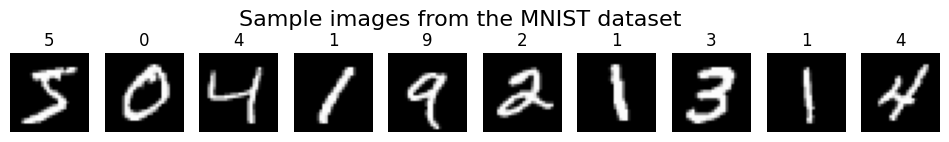

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
plot_mnist(mnist)

## K-Means Clustering

First we introduce ***K*-Means Clustering**, which is a simple approach for partitioning a data set into *K* distinct, non-overlapping clusters. Before we can apply this algorithm, we have to specify the number of clusters *K* that we would like to find in our data set. Often this is not clear from the beginning, however for our example we know that we got *K*=10 distinct groups that we would like to uncover (the digits 0 to 9). 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from umap import UMAP
import string

# Assuming mnist.data and mnist.target are loaded

umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap.fit_transform(mnist.data)

# K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_umap)

# Prepare colors
cmap = plt.get_cmap('tab10', 10)
colors = [cmap(i) for i in range(10)]

# Prepare cluster labels (A-J)
cluster_letters = list(string.ascii_uppercase[:10])

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# --- K-Means subplot ---
for i in range(10):
    idx = kmeans.labels_ == i
    axs[0].scatter(X_umap[idx, 0], X_umap[idx, 1], s=5, color=colors[i], label=f"Cluster {cluster_letters[i]}")
axs[0].set_title('K-Means Clusters on MNIST (UMAP)')
axs[0].legend(markerscale=3, fontsize="small")

# --- Original Labels subplot ---
for i in range(10):
    idx = mnist.target.astype(int) == i
    axs[1].scatter(X_umap[idx, 0], X_umap[idx, 1], s=5, color=colors[i], label=f"Digit {i}")
axs[1].set_title('True Labels on MNIST (UMAP)')
axs[1].legend(markerscale=3, fontsize="small")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\janic\OneDrive\Desktop\LLUI Lecture\.conda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


TODO: Add some text and comments, transition to Partitioning Around Medoids

In [ ]:
# Perform partitioning around medoids (PAM) visualize using UMAP

Add some more text

## Hierarchical Clustering